In [1]:
import math
import jax
from jax import jit, vmap, value_and_grad,lax
import jax.numpy as jnp
import optax
import jaxley as jx
import jaxley.optimize.transforms as jt
import jax.scipy as jsp
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

In [2]:
SAFE_Z   = 1e-4
EXP_CLIP = 60.0

def safe_exp(x): return jnp.exp(jnp.clip(x, -EXP_CLIP, EXP_CLIP))

def vtrap(dx, k):
    z = dx / k
    taylor = 1.0 - z/2.0 + (z*z)/12.0 - (z**4)/720.0
    return jnp.where(jnp.abs(z) < SAFE_Z, k * taylor, dx / jnp.expm1(z))

def alpha_m(v): return 0.1  * vtrap(25.0 - v, 10.0)
def beta_m(v):  return 4.0  * safe_exp(-v / 18.0)
def alpha_h(v): return 0.07 * safe_exp(-v / 20.0)
def beta_h(v):  return 1.0  / (safe_exp((30.0 - v)/10.0) + 1.0)
def alpha_n(v): return 0.01 * vtrap(10.0 - v, 10.0)
def beta_n(v):  return 0.125 * safe_exp(-v / 80.0)

def x_inf(alpha_fn, beta_fn, v):
    a, b = alpha_fn(v), beta_fn(v)
    return a / (a + b + 1e-12)

def gate_update(x, a, b, dt):
    inv_tau = a + b
    tau     = 1.0 / jnp.maximum(inv_tau, 1e-12)
    x_inf   = a * tau
    return jnp.clip(x_inf - (x_inf - x) * jnp.exp(-dt / tau), 0.0, 1.0)

# Cable coupling (axial G matrix)
def build_tridiagonal_gax(n_comp, g_link):
    """Line cable; uniform axial conductance g_link (S/cm^2 equiv)."""
    G = jnp.zeros((n_comp, n_comp))
    idx = jnp.arange(n_comp - 1)
    G = G.at[idx, idx+1].set(-g_link)
    G = G.at[idx+1, idx].set(-g_link)
    G = G.at[jnp.arange(n_comp), jnp.arange(n_comp)].set(-jnp.sum(G, axis=1))
    return G  # symmetric PSD

# One cable step (implicit V, RL gates)
@jit
def hh_step_cable(state, I_inj_vec, params, dt, Gax):
    """
    state: (v, m, h, n), each (N,)
    I_inj_vec: (N,)
    params: dict with per-comp arrays (N,) or scalars broadcastable
    Gax: (N,N) axial conductance matrix
    """
    v, m, h, n = state

    # rates at V_t
    am, bm = alpha_m(v), beta_m(v)
    ah, bh = alpha_h(v), beta_h(v)
    an, bn = alpha_n(v), beta_n(v)

    # Rush–Larsen gates → t+1
    m_new = gate_update(m, am, bm, dt)
    h_new = gate_update(h, ah, bh, dt)
    n_new = gate_update(n, an, bn, dt)

    gNa, gK, gL = params["HH_gNa"], params["HH_gK"], params["HH_gL"]
    ENa, EK, EL = params["HH_ENa"], params["HH_EK"], params["HH_EL"]
    Cm          = params["C_m"]

    # ionic conductances at t+1 gates (canonical m^3 h)
    gNa_eff = gNa * (m_new**3) * h_new
    gK_eff  = gK  * (n_new**4)
    gion    = gNa_eff + gK_eff + gL            # (N,)
    Irev    = gNa_eff*ENa + gK_eff*EK + gL*EL  # (N,)

    # implicit Euler: (C/dt I + diag(gion) + Gax) v_{t+1} = (C/dt) v_t + Irev + I_inj
    A = jnp.diag(Cm / dt + gion) + Gax
    b = (Cm/dt) * v + Irev + I_inj_vec
    L = jnp.linalg.cholesky(A)
    v_new = jsp.linalg.cho_solve((L, True), b) 


    return (v_new, m_new, h_new, n_new), v_new

def integrate_cable(state0, currents, params, dt, Gax):
    """currents: (T,N)"""
    def step(carry, I_t):
        return hh_step_cable(carry, I_t, params, dt, Gax)
    final_state, v_trace = lax.scan(step, state0, currents)
    return final_state, v_trace  # (T,N)

In [3]:
class MultiCompHH:
    def __init__(self, n_comp=5, default_params=None, g_link=0.2):
        self.n = n_comp
        base = {
            "HH_gNa": 120.0*jnp.ones(n_comp),
            "HH_gK":   36.0*jnp.ones(n_comp),
            "HH_gL":    0.3*jnp.ones(n_comp),
            "HH_ENa":  50.0*jnp.ones(n_comp),
            "HH_EK":  -77.0*jnp.ones(n_comp),
            "HH_EL":  -54.387*jnp.ones(n_comp),
            "C_m":      1.0*jnp.ones(n_comp),
        }
        if default_params is not None:
            base.update(default_params)
        self.params = base
        self.g_link = g_link
        self.Gax    = build_tridiagonal_gax(n_comp, g_link)

    def simulate(self, params_physical, currents, dt=0.025, t_equil_ms=25.0):
        """
        currents: (T,N), inject at soma via currents[:,0], others 0
        returns (T,N)
        """
        v0 = params_physical["HH_EL"]  # (N,)
        m0 = x_inf(alpha_m, beta_m, v0)
        h0 = x_inf(alpha_h, beta_h, v0)
        n0 = x_inf(alpha_n, beta_n, v0)
        state0 = (v0, m0, h0, n0)

        _, V = integrate_cable(state0, currents, params_physical, dt, self.Gax)
        return V


In [4]:
class IdentityTransform:
    def forward(self, x): return x
    def inverse(self, x): return x

def build_transform(n):
    return jx.ParamTransform({
        "HH_gNa": jt.SigmoidTransform(0.0, 400.0),     # (N,)
        "HH_gK":  jt.SigmoidTransform(0.0, 200.0),     # (N,)
        "HH_gL":  jt.SigmoidTransform(0.0,  10.0),     # (N,)
        "HH_ENa": jt.SigmoidTransform(-100.0, 100.0),  # (N,)
        "HH_EK":  jt.SigmoidTransform(-150.0,  50.0),
        "HH_EL":  jt.SigmoidTransform(-120.0,   0.0),
        "C_m":    IdentityTransform(),                
    })

In [5]:
def make_soma_step_batch(B, T, N, dt, delay=5.0, dur=20.0, amps=None, seed=0):
    t = jnp.arange(T) * dt
    mask = ((t >= delay) & (t < delay + dur)).astype(jnp.float32)  # (T,)
    if amps is None:
        rng = jax.random.PRNGKey(seed)
        amps = jax.random.normal(rng, (B,)) * 8.0  # (B,)
    I = jnp.zeros((B, T, N))
    I = I.at[:, :, 0].set(amps[:, None] * mask[None, :])  # soma-only
    return I, amps

def simulate_from_optparams(opt_params_pytree, batch_currents, model, dt=0.025):
    """
    batch_currents: (B,T,N)
    returns: (B,T,N)
    """
    params_physical = transform.forward(opt_params_pytree)  # dict of (N,)
    def one(bI):
        return model.simulate(params_physical, bI, dt=dt)
    return vmap(one)(batch_currents)

def loss_wave(opt_params_pytree, batch_currents, targets, model, dt):
    sim = simulate_from_optparams(opt_params_pytree, batch_currents, model, dt)
    return jnp.mean((sim - targets)**2)

def loss_mean(opt_params_pytree, batch_currents, targets, model, dt):
    sim = simulate_from_optparams(opt_params_pytree, batch_currents, model, dt)
    return jnp.mean((jnp.mean(sim, axis=(1,2)) - jnp.mean(targets, axis=(1,2)))**2)

# unified loss to avoid retraces when toggling
def unified_loss(opt_params_pytree, batch_currents, targets, model, dt, use_waveform: bool):
    def _wave(_):
        return loss_wave(opt_params_pytree, batch_currents, targets, model, dt)
    def _mean(_):
        return loss_mean(opt_params_pytree, batch_currents, targets, model, dt)
    return lax.cond(use_waveform, _wave, _mean, operand=None)

In [6]:
PARAM_KEYS_TO_TRACK = ["HH_gNa", "HH_gK", "HH_ENa", "HH_EK", "HH_EL"]

def tree_global_l2(tree):
    return optax.global_norm(tree)

def tree_param_l2s(grads, keys=PARAM_KEYS_TO_TRACK):
    out = {}
    for k in keys:
        if k in grads:
            out[k] = jnp.sqrt(jnp.sum(jnp.square(grads[k])))  # across compartments
    return out

def ema(xs, alpha=0.9):
    if not xs: return []
    sm = [xs[0]]
    for x in xs[1:]:
        sm.append(alpha*sm[-1] + (1-alpha)*x)
    return sm

In [7]:
N  = 5
dt = 0.025
t_max = 50.0
T = int(math.ceil(t_max / dt))
model = MultiCompHH(n_comp=N, g_link=0.2)

transform = build_transform(N)
params_phys0 = model.params
opt_params0  = transform.inverse(params_phys0)

# Batch currents
B = 32
batch_currents, amps = make_soma_step_batch(B, T, N, dt, delay=5.0, dur=20.0, seed=0)

# Teacher
teacher_opt = transform.inverse(transform.forward(opt_params0))  # identity, explicit
with jax.disable_jit():
    teacher_volts = simulate_from_optparams(teacher_opt, batch_currents, model, dt)  # (B,T,N)

USE_WAVEFORM = True
targets = teacher_volts

# Learner init (perturb a few params)
learner_phys = {k: v.copy() for k, v in params_phys0.items()}
learner_phys["HH_gNa"] = learner_phys["HH_gNa"] * 0.8
learner_phys["HH_gK"]  = learner_phys["HH_gK"]  * 1.1
learner_phys["HH_EL"]  = learner_phys["HH_EL"]  + 2.0
params = transform.inverse(learner_phys)

from jax import tree_util as tu

# Boolean mask (same pytree as params): True = train, False = freeze
mask = tu.tree_map(lambda x: jnp.ones_like(x, dtype=bool), params)

optimizer = optax.chain(
optax.clip_by_global_norm(1.0),
optax.adamw(1e-3),
)
opt_state = optimizer.init(params)

# JIT loss/grad
grad_fn = jit(value_and_grad(lambda p, I, Y: unified_loss(p, I, Y, model, dt, USE_WAVEFORM), argnums=0))

# Logs
loss_hist = []
grad_hist_global = []
grad_hist_perkey = {k: [] for k in PARAM_KEYS_TO_TRACK}

steps = 1000
for step in range(steps+1):
    loss_val, grads = grad_fn(params, batch_currents, targets)

    # record grads
    gnorm = float(tree_global_l2(grads))
    per   = tree_param_l2s(grads)
    loss_hist.append(float(loss_val))
    grad_hist_global.append(gnorm)
    for k in grad_hist_perkey:
        grad_hist_perkey[k].append(float(per.get(k, 0.0)))

    # update
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if step % 50 == 0:
        print(f"step {step:4d}  loss={float(loss_val):.3e}  gnorm={gnorm:.3e}")


Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/n/home12/isanchez/.conda/envs/itzeljax/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/n/home12/isanchez/.conda/envs/itzeljax/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


step    0  loss=3.999e+00  gnorm=5.279e+01
step   50  loss=2.683e-01  gnorm=1.354e+01
step  100  loss=3.291e-04  gnorm=4.679e-01
step  150  loss=3.301e-06  gnorm=3.568e-02
step  200  loss=7.254e-07  gnorm=1.869e-03
step  250  loss=5.499e-07  gnorm=9.513e-05
step  300  loss=4.275e-07  gnorm=1.502e-05
step  350  loss=3.291e-07  gnorm=1.082e-05
step  400  loss=2.493e-07  gnorm=9.768e-06
step  450  loss=1.859e-07  gnorm=8.988e-06
step  500  loss=1.364e-07  gnorm=8.334e-06
step  550  loss=9.855e-08  gnorm=7.798e-06
step  600  loss=7.014e-08  gnorm=7.357e-06
step  650  loss=4.917e-08  gnorm=6.993e-06
step  700  loss=3.397e-08  gnorm=6.688e-06
step  750  loss=2.313e-08  gnorm=6.426e-06
step  800  loss=1.553e-08  gnorm=6.197e-06
step  850  loss=1.030e-08  gnorm=5.992e-06
step  900  loss=6.756e-09  gnorm=5.803e-06
step  950  loss=4.402e-09  gnorm=5.625e-06
step 1000  loss=2.865e-09  gnorm=5.457e-06


Final RMSE (waveform): 5.3296962537855734e-05
HH_gNa  Max Abs Deviation = 24.023124
HH_gK   Max Abs Deviation = 5.063945
HH_gL   Max Abs Deviation = 0.000002
HH_ENa  Max Abs Deviation = 0.804859
HH_EK   Max Abs Deviation = 2.446682
HH_EL   Max Abs Deviation = 0.000020
C_m     Max Abs Deviation = 0.000007


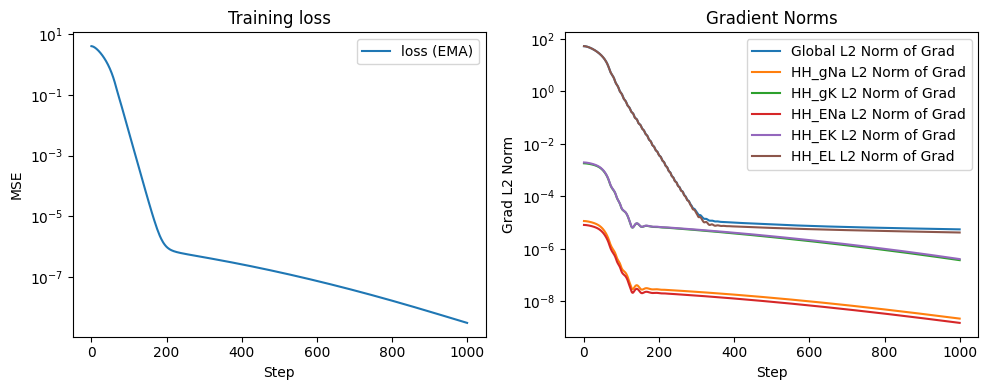

In [9]:
# Final waveform RMSE on training batch
sim_final = simulate_from_optparams(params, batch_currents, model, dt)
rmse = float(jnp.sqrt(jnp.mean((sim_final - targets)**2)))
print("Final RMSE (waveform):", rmse)

# Parameter diffs 
phys_est  = transform.forward(params)
phys_true = transform.forward(teacher_opt)
for k in ["HH_gNa","HH_gK","HH_gL","HH_ENa","HH_EK","HH_EL","C_m"]:
    if k in phys_est:
        delta = float(jnp.max(jnp.abs(phys_est[k] - phys_true[k])))
        print(f"{k:7s} Max Abs Deviation = {delta:.6f}")

steps_ax = range(len(loss_hist))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(steps_ax, ema(loss_hist, 0.9), label="loss (EMA)")
plt.yscale("log"); plt.xlabel("Step"); plt.ylabel("MSE"); plt.title("Training loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(steps_ax, ema(grad_hist_global, 0.9), label="Global L2 Norm of Grad")
for k, series in grad_hist_perkey.items():
    if any(s > 0 for s in series):
        plt.plot(steps_ax, ema(series, 0.9), label=f"{k} L2 Norm of Grad")
plt.yscale("log"); plt.xlabel("Step"); plt.ylabel("Grad L2 Norm"); plt.title("Gradient Norms")
plt.legend()
plt.tight_layout()
plt.show()

Experiment 1


In [ ]:
def make_step_injection(T, N, dt, inj_idx, delay=5.0, dur=20.0, amp=8.0):
    t = jnp.arange(T) * dt
    mask = ((t >= delay) & (t < delay + dur)).astype(jnp.float64)  # T,
    I = jnp.zeros((T, N), dtype=jnp.float64)
    I = I.at[:, inj_idx].set(amp * mask)
    return I  # (T, N)

In [ ]:
def loss_soma_mse(phys_params, currents, target_soma, model, dt):
    V = model.simulate(phys_params, currents, dt=dt)   # (T, N)
    pred_soma = V[:, 0]
    return jnp.mean((pred_soma - target_soma)**2), pred_soma  # return pred for factorization

In [ ]:
def replace_scalar(tree, key, idx, new_val):
    return { **tree, key: tree[key].at[idx].set(new_val) }

def vsoma_from_scalar_param(p_scalar, phys_params, key, idx, currents, model, dt):
    new_params = replace_scalar(phys_params, key, idx, p_scalar)
    V = model.simulate(new_params, currents, dt=dt)
    return V[:, 0]  # (T,)

def dVsoma_dp(phys_params, key, idx, currents, model, dt):
    p0 = phys_params[key][idx]
    f  = lambda p_scalar: vsoma_from_scalar_param(p_scalar, phys_params, key, idx, currents, model, dt)
    # jacobian fwd over a scalar -> returns a (T,) sensitivity
    return jax.jacfwd(f)(p0)  # (T,)

In [ ]:
def dL_dVsoma(pred_soma, target_soma):
    T = pred_soma.shape[0]
    return (2.0 / T) * (pred_soma - target_soma)  # (T,)

In [14]:
def chain_check(dL_dV, dV_dp, grad_p):
    return float(jnp.vdot(dL_dV, dV_dp)), float(grad_p)

In [ ]:
N  = 5
dt = 0.025
t_max = 50.0
T = int(math.ceil(t_max / dt))
model = MultiCompHH(n_comp=N, g_link=0.2)

# true teach physical params
phys_true = model.params

# Build per-injection targets
delay, dur, amp = 5.0, 20.0, 8.0
inj_currents = [make_step_injection(T, N, dt, i, delay, dur, amp) for i in range(N)]
targets_soma = []
with jax.disable_jit():
    for I_i in inj_currents:
        Vt = model.simulate(phys_true, I_i, dt=dt)
        targets_soma.append(Vt[:, 0])
targets_soma = [jnp.asarray(ts) for ts in targets_soma]

# perturbed physical params for learner
phys_learner = {k: v.copy() for k, v in phys_true.items()}
phys_learner["HH_gNa"] = phys_learner["HH_gNa"] * 0.8
phys_learner["HH_gK"]  = phys_learner["HH_gK"]  * 1.1
phys_learner["HH_EL"]  = phys_learner["HH_EL"]  + 2.0

# value_and_grad of the soma loss wrt physical params
loss_and_grad_phys = jax.value_and_grad(
    lambda p, I, y: loss_soma_mse(p, I, y, model, dt)[0],
    argnums=0
)

# 5x2 matrix of grads and the factorization check
G = jnp.zeros((N, 2), dtype=jnp.float64)        # [i, 0]=dL/dgK[i], [i,1]=dL/dgNa[i]
factor_dot = jnp.zeros_like(G)                  # same shape: dot(dL/dV, dV/dp)

for i in range(N):
    I_i, y_i = inj_currents[i], targets_soma[i]

    # full gradient
    (loss_i), grads_phys = loss_and_grad_phys(phys_learner, I_i, y_i)
    gK_i  = grads_phys["HH_gK"][i]
    gNa_i = grads_phys["HH_gNa"][i]
    G = G.at[i, 0].set(gK_i)
    G = G.at[i, 1].set(gNa_i)

    # factorization pieces
    loss_i_val, pred_soma_i = loss_soma_mse(phys_learner, I_i, y_i, model, dt)
    dL_dV = dL_dVsoma(pred_soma_i, y_i)               # (T,)
    sens_K  = dVsoma_dp(phys_learner, "HH_gK",  i, I_i, model, dt)   # (T,)
    sens_Na = dVsoma_dp(phys_learner, "HH_gNa", i, I_i, model, dt)   # (T,)

    # dot products (chain rule)
    factor_dot = factor_dot.at[i, 0].set(jnp.vdot(dL_dV, sens_K))
    factor_dot = factor_dot.at[i, 1].set(jnp.vdot(dL_dV, sens_Na))

print("Gradient matrix G [inj_idx x {gK, gNa}]:\n", G)
print("Factorized dot(dL/dV_soma, dV_soma/dp):\n", factor_dot)
print("Max |difference| between full grad and factorized dot:",
      float(jnp.max(jnp.abs(G - factor_dot))))


Gradient matrix G [inj_idx x {gK, gNa}]:
 [[-3.93363527e-05  4.58515013e-08]
 [-3.19931907e-06  3.14581671e-09]
 [-9.03549304e-07  8.78537889e-10]
 [-3.23494034e-07  3.18833679e-10]
 [-4.97822171e-07  5.82891948e-10]]
Factorized dot(dL/dV_soma, dV_soma/dp):
 [[-3.93363527e-05  4.58515013e-08]
 [-3.19931907e-06  3.14581671e-09]
 [-9.03549304e-07  8.78537889e-10]
 [-3.23494034e-07  3.18833679e-10]
 [-4.97822171e-07  5.82891948e-10]]
Max |difference| between full grad and factorized dot: 1.3552527156068805e-20


In [ ]:
inj_list  = [make_step_injection(T, N, dt, i, 5.0, 20.0, 8.0) for i in range(N)]
targets   = []
with jax.disable_jit():
    for I in inj_list:
        targets.append(model.simulate(model.params, I, dt)[:, 0])  # teacher soma

def loss_all_injections(phys_params):
    def one(I, y):
        V = model.simulate(phys_params, I, dt)[:, 0]
        return jnp.mean((V - y)**2)
    return jnp.mean(jnp.array([one(I, y) for I, y in zip(inj_list, targets)]))

loss_val, g_phys = jax.value_and_grad(loss_all_injections)(phys_est_initial)
